# Rate Analyses by Cue and section

exploratory analysis to understand the reason for rate remapping

In [1]:
%matplotlib inline
import numpy as np
import scipy.stats
from scipy.stats import ttest_ind, ttest_1samp
import pandas as pd
from importlib import reload
from pathlib import Path


import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
from matplotlib import cm
from matplotlib.colors import ListedColormap
import seaborn as sns


import statsmodels.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats

import TreeMazeAnalyses2,Analyses.tree_maze_functions as tmf
import TreeMazeAnalyses2.Analyses.experiment_info as ei
import TreeMazeAnalyses2.Analyses.plot_functions as pf
import TreeMazeAnalyses2.Utils.robust_stats as rs

import ipywidgets as widgets
from ipywidgets import interact, fixed, interact_manual

from joblib import delayed, Parallel

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)



In [2]:
ei = reload(ei)
info = ei.SummaryInfo()

In [3]:
%%time
overwrite=False
zrc_exp = 2
if zrc_exp == 0:
    params = dict()
    zrc_str = ''
elif zrc_exp==1:
    params=dict(trial_end='tE_1')
    zrc_str = 'tE_1'
elif zrc_exp==2:
    params=dict(trial_end='tE_2')
    zrc_str = 'tE_2'
elif zrc_exp==3:
    params=dict(reward_blank=True)
    zrc_str = 'rwb'
elif zrc_exp==4:
    params=dict(trial_end='tD')
    zrc_str = 'tD'
    
zrc = info.get_zone_rates_remap(overwrite=overwrite, **params)
remap_measures = zrc.columns[10:]

CPU times: user 34 ms, sys: 0 ns, total: 34 ms
Wall time: 32.2 ms


## Population level results

In [5]:
fig_path = Path('/home/alexgonzalez/Documents/treemazefigs/rate_comparisons/')
dpi=2000

In [6]:
segment_rate_comps = info.get_segment_rate_comps()
segment_rate_comps['segment'] = segment_rate_comps['segment'].astype(
            pd.api.types.CategoricalDtype(['left', 'stem', 'right']))

comps = ['cue', 'rw', 'dir']
unit_types = ['cell', 'mua', 'all']
metrics = ['t_val', 'uz_val']

In [9]:
def plot_comp_score_x_seg(data, comp='cue', metric='t_val', ax=None):
    n_partition_colors = 100
    n_colors = n_partition_colors*2+1
    
    if comp=='cue':
        bottom = cm.get_cmap('Purples', n_partition_colors)
        top = cm.get_cmap('Greens_r', n_partition_colors)
        cm_name = 'PG'
        text_grad = ['LC', 'RC']
    elif comp=='rw':
        bottom = cm.get_cmap('Blues', n_partition_colors)
        top = cm.get_cmap('Reds_r', n_partition_colors)
        cm_name = 'BR'
        text_grad = ['NRW', 'RW']
    else:
        bottom = cm.get_cmap('Oranges', n_partition_colors)
        top = cm.get_cmap('Greys_r', n_partition_colors)
        cm_name = 'OG'
        text_grad = ['In', 'Out']
        
    
    color_map = np.vstack((top(np.linspace(0, 1, n_partition_colors)),
                       (1,1,1,1),
                       bottom(np.linspace(0, 1, n_partition_colors))))
    color_map_plt = ListedColormap(color_map, name=cm_name)

    df = data
    scatter_spread = 0.12
    scatter_point_size = 2
    fontsize = 10
    median_lw = 1.5
    violin_plot_lw =0.5
    metric_score_txt = fontsize-3
    scatter_alpha = 0.8

    if metric == 't_val':
        metric_label1 = metric_label2 = 'T'
    elif metric == 'uz_val':
        #metric_label = text_grad[0] + f" $\leftarrow U_Z \rightarrow$ " + text_grad[1]
        metric_label1 = text_grad[0] + r" $\leftarrow U_Z \rightarrow$ "  + text_grad[1]
        metric_label2 = f"$U_Z$"
        #metric_label2 = r"$\rightarrow$"
    else:
        metric_label1 = metric_label2 = ''

    if ax is None:
        f,ax=plt.subplots(figsize=(2,2),dpi=300)
        cax = f.add_axes([0.95,0.2,0.05,0.2])

    else:
        f = ax.figure
        ax_pos =  ax.get_position()
        cax = f.add_axes([(ax_pos.x0+ax_pos.width)*1.05,
                          ax_pos.y0+ax_pos.height*0.2,
                         ax_pos.width/15,
                         ax_pos.height/3.8])
        
    sns.violinplot(data=df, x='segment', y=metric, 
                   color='0.95', inner='quartile', bw=0.5,linewidth=violin_plot_lw, ax=ax)
    
    
    medians = np.zeros(3)
    for ii,seg in enumerate(['left', 'stem', 'right']):
        medians[ii] = np.around(df.loc[df.segment==seg, metric].median(),2)
        
    s = np.zeros((len(ax.get_children()),2))-1
    ax_artists = ax.get_children()

    for ii, l in enumerate(ax_artists):
        if isinstance(l, mpl.lines.Line2D):
            s[ii] = l._dashSeq

    median_lines_idx = np.where(s[:,0]==s.max())[0]
    quartile_lines_idx = np.where(s>0)[0]
    quartile_lines_idx = np.setdiff1d(quartile_lines_idx, median_lines_idx)

    for ii in median_lines_idx:
        ax_artists[ii].set_lw(median_lw)
        ax_artists[ii].set_ls('-')

    for jj in quartile_lines_idx:
        ax_artists[jj].remove()
        
    ax.set_ylabel(metric_label1, labelpad=0, fontsize=fontsize)
    ax.set_xlabel('Segment', labelpad=0, fontsize=fontsize)

    for ch in ax.get_children():
        if isinstance(ch, mpl.collections.PolyCollection):
            ch.set_edgecolor('0.4')
        elif isinstance(ch, mpl.lines.Line2D):
            ch.set_color('0.4')
    colors, value_color_map_array = pf.get_colors_from_data(df[metric], div=True, color_map=color_map, n_color_bins = n_colors)

    for ii, seg in enumerate(['left', 'stem', 'right']):
        idx = df.segment==seg
        vals = df.loc[idx, metric]
        x_locs =  np.random.triangular(-scatter_spread,0,scatter_spread, size=idx.sum()) + ii
        ax.scatter(x_locs, vals, s=scatter_point_size, color=colors[idx], 
                   linewidths=scatter_point_size/30, edgecolors='0.3', zorder=10, alpha=scatter_alpha)

    sns.despine(ax=ax)
    ax.tick_params(axis='both', bottom=True, left=True, labelsize=fontsize-2, pad=1, length=2, width=1, color='0.2', which='major')

    for sp in ['bottom', 'left']:
        ax.spines[sp].set_linewidth(1)
        ax.spines[sp].set_color('0.2')

    ax.grid(linewidth=0.5, axis='y')
    pf.get_color_bar_axis(cax, color_array=value_color_map_array, color_map=color_map_plt , skip_labels=True)
    cax.text(1.05,1,np.around(value_color_map_array[-1],1), fontsize=fontsize/2, ha='left', va='center', transform=cax.transAxes)
    cax.text(1.5,0.5, metric_label2, fontsize=fontsize/1.5, ha='left', va='center', transform=cax.transAxes)
    cax.text(1.05,0,np.around(value_color_map_array[0],1), fontsize=fontsize/2, ha='left', va='center', transform=cax.transAxes)

    
    ylims = ax.get_ylim()
    ax.set_ylim([ylims[0]-0.1*abs(ylims[0]), ylims[1]])
    
    for ii in range(3):
        #ax.text(ii, ylims[0]*1.02, medians[ii], ha='center', va='bottom', fontsize=metric_score_txt)
        ax.text((ii+0.5)/3, 1 , medians[ii], ha='center', va='bottom', fontsize=metric_score_txt, transform=ax.transAxes)
    
    return f,ax,cax
    
def comp_cond_summary(comp='cue', unit_type='cell', metric='uz_val', savefig=False):
    
    f,ax,cax=plot_comp_score_x_seg(df, comp=comp, metric=metric )
    
    if savefig:
        fn = f"{comp}_{unit_type}_{metric}_rate_segment_comp.png"
        f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')
        
    if unit_type!='all':
        df =segment_rate_comps[(segment_rate_comps.comp==comp) & 
                            (segment_rate_comps.unit_type==unit_type)].copy()
    else:
        df =segment_rate_comps[(segment_rate_comps.comp==comp)].copy()

    
    df['score'] = df[metric]

    vc_formula={}
    if comp=='rw':
        vc_formula['task'] = "0+C(task)"
    else:
        vc_formula['task'] = "1+C(task)"
    vc_formula['session'] = "0+C(session)"

    if unit_type=='all':
        mdf = smf.mixedlm(formula="score ~ 0 + segment + unit_type", groups='subject', re_formula="1", vc_formula=vc_formula, data=df).fit()
        r_mat = np.array([[1,-1,0, 0],[0,-1,1, 0],[-1,0,1, 0]])
    else:
        mdf = smf.mixedlm(formula="score ~ 0 + segment", groups='subject', re_formula="1", vc_formula=vc_formula, data=df).fit()
        r_mat = np.array([[1,-1,0],[0,-1,1],[-1,0,1]])

    print(mdf.summary())
    print(mdf.wald_test_terms())
    
    print()
    print("Interactions")
    print('c0: left>stem')
    print('c1: stem>right')
    print('c2: right>left')
    print(mdf.t_test(r_mat))
    
    return(f)

In [10]:
_ = widgets.interact_manual(comp_cond_summary, comp=comps, unit_type=unit_types, metric=metrics)

interactive(children=(Dropdown(description='comp', options=('cue', 'rw', 'dir'), value='cue'), Dropdown(descri…

In [24]:
comp = 'rw'
unit_type='cell'
metric = 'uz_val'

if unit_type!='all':
    df =segment_rate_comps[(segment_rate_comps.comp==comp) & 
                        (segment_rate_comps.unit_type==unit_type)].copy()
else:
    df =segment_rate_comps[(segment_rate_comps.comp==comp)].copy()


df['score'] = df[metric]

vc_formula={}
if comp=='rw':
    vc_formula['task'] = "0+C(task)"
else:
    vc_formula['task'] = "1+C(task)"
vc_formula['session'] = "0+C(session)"

if unit_type=='all':
    mdf = smf.mixedlm(formula="score ~ 0 + segment + unit_type", groups='subject', re_formula="1", vc_formula=vc_formula, data=df).fit()
    r_mat = np.array([[1,-1,0, 0],[0,-1,1, 0],[-1,0,1, 0]])
else:
    mdf = smf.mixedlm(formula="score ~ 0 + segment", groups='subject', re_formula="1", vc_formula=vc_formula, data=df).fit()
    r_mat = np.array([[1,-1,0],[0,-1,1],[-1,0,1]])

print(mdf.summary())
print(mdf.wald_test_terms())

print()
print("Interactions")
print('c0: left>stem')
print('c1: stem>right')
print('c2: right>left')
print(mdf.t_test(r_mat))

          Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: score     
No. Observations:  1695    Method:             REML      
No. Groups:        5       Scale:              2.8479    
Min. group size:   60      Log-Likelihood:     -3344.0377
Max. group size:   822     Converged:          Yes       
Mean group size:   339.0                                 
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
segment[left]  -0.511    0.280 -1.827 0.068 -1.059  0.037
segment[stem]  -0.338    0.280 -1.210 0.226 -0.886  0.210
segment[right] -1.036    0.280 -3.707 0.000 -1.584 -0.488
subject Var     0.316                                    
session Var     0.255    0.048                           
task Var        0.053                                    

              chi2        P>chi2  df constraint
segment  57.759963  1.768763e-12 

In [25]:
mdf.pvalues

segment[left]     0.067704
segment[stem]     0.226396
segment[right]    0.000209
subject Var            NaN
session Var       0.001777
task Var               NaN
dtype: float64

In [17]:
mdf = smf.mixedlm(formula="score~+1", groups='subject', re_formula="1", vc_formula=vc_formula, data=df).fit()
print(mdf.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: score     
No. Observations: 1695    Method:             REML      
No. Groups:       5       Scale:              2.9486    
Min. group size:  60      Log-Likelihood:     -3367.7247
Max. group size:  822     Converged:          No        
Mean group size:  339.0                                 
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     -0.649    0.299 -2.173 0.030 -1.234 -0.063
subject Var    0.261                                    
session Var    0.214    0.041                           
task Var       0.215                                    



In [23]:
scipy.stats.ttest_1samp(df[df.segment=='left'].uz_val,0)

Ttest_1sampResult(statistic=-9.332447709577696, pvalue=2.350587893421188e-19)

## Examine the effects on one session

In [156]:

subject_widget = widgets.Dropdown(options=info.subjects)
session_widget = widgets.Dropdown(options=info.sessions_by_subject[subject_widget.value])
task_widget = widgets.Dropdown(options=['T3', 'OF'])

def update_sessions(*args):
    all_sessions = info.sessions_by_subject[subject_widget.value]
    task_sessions = [session for session in all_sessions if task_widget.value in session]
    session_widget.options = task_sessions

def get_session(subject, task, session):
    return ei.SubjectSessionInfo(subject, session)

subject_widget.observe(update_sessions, names='value')
task_widget.observe(update_sessions, names='value')
o=widgets.interactive(get_session, subject=subject_widget, task=task_widget, session=session_widget)
display(o)

interactive(children=(Dropdown(description='subject', options=('Li', 'Ne', 'Cl', 'Al', 'Ca', 'Mi'), value='Li'…

In [157]:
session = session_widget.value
session_info = o.result
print(session_info)


Session Information for subject Li, session Li_T3g_062018
Number of curated units: 26
Methods listed below can be executed with get_{method}(), eg. get_spikes():
  -> track_data. Executed = True
  -> spikes. Executed = True
  -> binned_spikes. Executed = True
  -> fr. Executed = True
  -> pos_zones. Executed = True
  -> event_table. Executed = True
  -> trial_zone_rates. Executed = False
  -> zone_rates_comps. Executed = True
  -> zone_rates_remap. Executed = True
  -> pop_zone_rates_remap. Executed = True
  -> bal_conds_seg_rates. Executed = True
  -> bal_conds_seg_boot_rates. Executed = nan
  -> zone_encoder. Executed = True
  -> zone_decoder. Executed = True

To run all analyses use run_analyses().



In [158]:
tmf=reload(tmf)
tmz = tmf.TreeMazeZones()
ta = tmf.TrialAnalyses(session_info)

In [159]:
def plot_zone_seq(zone_seq, legend=True, ax=None):
    if ax is None:
        f,ax=plt.subplots(figsize=(2.5,1.8),dpi=300)
        return_fig = True
    else:
        f = ax.figure
        return_fig = False
        
    lw =2.5
    x1 = np.arange(9)
    x2 = np.arange(9, 16)
    x3 = np.arange(16, tmz.max_seq_length)
    
    #cols = plt.cm.Paired([8,9,2,3])
    cols2 = plt.cm.tab20b([12,0])
    cols4 = plt.cm.tab20b([12,15,0,3])
    
    stem_y = zone_seq[tmz.all_zone_goal_seqs['G1'].values[x1]]
    ax.plot(x1, stem_y, lw=lw, alpha=0.75 , label='stem', color='k')
    
    right_y = zone_seq[tmz.all_zone_goal_seqs['G1'].values[x2]]
    ax.plot(x2, right_y, lw=lw, alpha=0.75 , color=cols2[0])#color=tmz.split_colors['right'])
    
    left_y = zone_seq[tmz.all_zone_goal_seqs['G3'].values[x2]]
    ax.plot(x2, left_y, lw=lw, alpha=0.75 , color=cols2[1])#color=tmz.split_colors['left'])
    
    for ii, g in enumerate(tmz.goal_wells):
        seq = zone_seq[tmz.all_zone_goal_seqs[g].values[x3]]
        ax.plot(x3, seq, lw=lw/1.5, alpha=0.75, color=cols4[ii], label=g)
    ax.set_xticks([0,8,15,19])
    ax.set_xticklabels(['H', 'D', 'i', 'G'])
    ax.set_xlabel('Zone', fontsize=fontsize)

    if legend:
        ax.legend()

        ha,la = ax.get_legend_handles_labels()
        ax.get_legend().remove()

        ax.legend(ha,la,bbox_to_anchor = [1,0.1,0.2,0.5], frameon=False, fontsize=fontsize-3,
                  markerscale=0.2, handlelength=0.5, labelspacing=0.2)
    
    sns.despine(ax=ax)
    ax.tick_params(axis='both', bottom=True, left=True, labelsize=fontsize-2, pad=1, length=2, width=1, color='0.2', which='major')

    for sp in ['bottom', 'left']:
        ax.spines[sp].set_linewidth(1)
        ax.spines[sp].set_color('0.2')
        
    if return_fig:
        return f, ax

def plot_cond_zone_seq(trial_analyses, cond, unit=0, trial_seg='out', ax=None):
    if ax is None:
        f,ax = plt.subplots()
    else:
        f = ax.figure
        
    trials = trial_analyses.get_condition_trials(cond)
    zone_seq = trial_analyses.get_avg_trial_zone_rates(trials=trials, 
                                                       occupation_trial_samp_thr=5, 
                                                       trial_seg=trial_seg)
    plot_zone_seq(zone_seq.loc[unit], ax=ax)

def plot_cond_track_spikes(trial_analyses, cond, unit=0, trial_seg='out', ax=None):
    
    lw = 0.1 # line width
    la = 0.3 # line alpha
    lc = '0.5' # line color
    
    ss = 1 # scatter scale
    sc = 'r' # scatter color 
    sa = 0.1 # scatter alpha
    
    if ax is None:
        f,ax = plt.subplots()
    else:
        f = ax.figure
        
    trials = trial_analyses.get_condition_trials(cond)
    x,y, _ = trial_analyses.get_trial_track_pos(trials, trial_seg)
    spk = trial_analyses.get_trial_neural_data(trials, data_type='spikes', trial_seg=trial_seg)[unit]
    
    for ii, tr in enumerate(trials):
        ax.plot(x[ii], y[ii], linewidth=lw, alpha=la, color=lc, zorder=-1)
        ax.scatter(x[ii], y[ii], s=spk[ii]*ss, color=sc, alpha=sa, linewidth=0)

    ax.axis("square")
    ax.axis("off")
    ax.set_ylim(trial_analyses.y_edges[0], trial_analyses.y_edges[-1])
    ax.set_xlim(trial_analyses.x_edges[0], trial_analyses.x_edges[-1])
    
    return ax

def plot_cond_rate_map(trial_analyses, cond, unit=0, trial_seg='out', ax=None):
    cmap = 'viridis'
    
    if ax is None:
        f,ax = plt.subplots()
    else:
        f = ax.figure    
    
    trials = trial_analyses.get_condition_trials(cond)
    fr_map = trial_analyses.get_trial_rate_maps(trials=trials, trial_seg='out', occ_rate_mask=True)
    
    ax = sns.heatmap(fr_map, cbar=False, square=True, cmap=cmap, ax=ax)
    ax.invert_yaxis()
    ax.axis("off")
    
    data = fr_map.flatten()
    data_colors, color_array = pf.get_colors_from_data(data, cmap=cmap)
    
    ax_p = ax.get_position()
    w, h = ax_p.width, ax_p.height
    x0,y0 = ax_p.x0, ax_p.y0

    cax_p = [x0+w*0.85, y0+h*0.05, w*0.05, h*0.15]
    cax = f.add_axes(cax_p)

    pf.get_color_bar_axis(cax, color_array, color_map=cmap, label='FR')

def plot_zone_rates(trial_analyses, cond, unit=0, trial_seg='out', ax=None, 
                    min_value=0, max_value=None, label='FR', color_map='viridis', div=False):
    if ax is None:
        f,ax = plt.subplots()
    else:
        f = ax.figure
    
    trials = trial_analyses.get_condition_trials(cond)
    zr = trial_analyses.get_unit_trial_zone_rates(unit = unit, trials=trials, trial_seg=trial_seg).mean()
    tmz.plot_zone_activity(zr,  ax=ax, min_value=min_value, max_value=max_value, color_map=color_map, label=label)
    ax.axis('square')
       

In [160]:
trial_seg_rates = {}
for trial_seg in ['out','in']:
    trial_seg_rates[trial_seg]=ta.get_trial_segment_rates(trial_seg=trial_seg, segment_type='bigseg')
    
trial_zone_u_comps = {}
for comp in comps:
    if comp == 'cue':
        conds = ['CR', 'CL']
        trial_segs = ['out']*2

    elif comp == 'rw':
        conds = ['Co', 'Inco']
        trial_segs = ['in']*2

    elif comp == 'dir':
        conds = ['Out', 'In']
        trial_segs = ['out','in']

    
    trials=[ta.get_condition_trials(condition=conds[0]),
            ta.get_condition_trials(condition=conds[1])
           ]
    trial_zone_u_comps[comp] = ta.zone_rate_maps_uz(cond1=conds[0], cond2=conds[1], trial_seg1=trial_segs[0], trial_seg2=trial_segs[1])

interactive(children=(Dropdown(description='comp', options=('cue', 'rw', 'dir'), value='cue'), IntSlider(value…

Button(description='Save Figure', style=ButtonStyle())

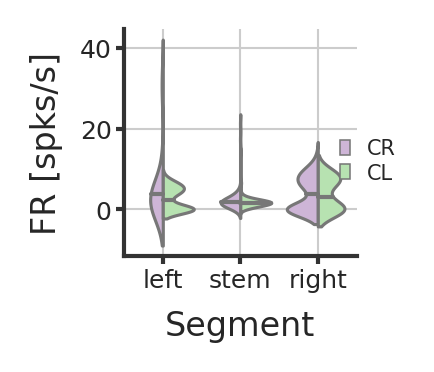

In [174]:
unit_widget2 = widgets.IntSlider(value=0, max=ta.n_units-1)
comp_widget2 = widgets.Dropdown(options=comps)
save_button2 = widgets.Button(description='Save Figure')
fontsize=8

def plot_seg_cond_comp(comp=comp_widget2, unit=unit_widget2):
    
    f,ax = plt.subplots(figsize=(1,1), dpi=300)
    median_lw = 1
    violin_lw = 0.75
    
    if comp == 'cue':
        conds = ['CR', 'CL']
        trial_segs = ['out']*2
        cond_names = ['RC', 'LC']
        palette='PRGn'
    elif comp == 'rw':
        conds = ['Co', 'Inco']
        trial_segs = ['in']*2
        cond_names = ['RW', 'NRW']
        palette='RdBu_r'
    elif comp == 'dir':
        conds = ['Out', 'In']
        trial_segs = ['out','in']
        cond_names = ['Out', 'In']
        palette='RdGy'

    
    trials=[ta.get_condition_trials(condition=conds[0]),
            ta.get_condition_trials(condition=conds[1])]
    
    df = pd.DataFrame()
    for ii in range(2):
        res = trial_seg_rates[trial_segs[ii]][unit].loc[trials[ii]].melt(value_name='FR', 
                                                                         var_name='segment',
                                                                         ignore_index=False).reset_index(drop=True)
        res['cond'] = conds[ii]
        df = pd.concat((df,res))
    df = df.reset_index(drop=True)
    
    sns.violinplot(data=df, x='segment', y='FR', hue='cond', split=True, 
                   inner='quartile', palette=palette, hue_order=conds, 
                   saturation=100, linewidth=violin_lw, ax=ax)
    
#     medians = np.zeros(3)
#     for ii,seg in enumerate(['left', 'stem', 'right']):
#         medians[ii] = np.around(df.loc[df.segment==seg, metric].median(),2)
        
    s = np.zeros((len(ax.get_children()),2))-1
    ax_artists = ax.get_children()

    for ii, l in enumerate(ax_artists):
        if isinstance(l, mpl.lines.Line2D):
            s[ii] = l._dashSeq

    median_lines_idx = np.where(s[:,0]==s.max())[0]
    quartile_lines_idx = np.where(s>0)[0]
    quartile_lines_idx = np.setdiff1d(quartile_lines_idx, median_lines_idx)

    for ii in median_lines_idx:
        ax_artists[ii].set_lw(median_lw)
        ax_artists[ii].set_l125 Oak Cts('-')

    for jj in quartile_lines_idx:
        ax_artists[jj].remove()
    
    sns.despine(ax=ax)
    ax.tick_params(axis='both', bottom=True, left=True, labelsize=fontsize-2, 
                   pad=1, length=2, width=1, color='0.2', which='major')
    ax.set_xlabel("Segment",fontsize=fontsize)
    ax.set_ylabel("FR [spks/s]", fontsize=fontsize)

    for sp in ['bottom', 'left']:
        ax.spines[sp].set_linewidth(1)
        ax.spines[sp].set_color('0.2')

    ax.grid(linewidth=0.5)
    
    ax.legend()

    ha,la = ax.get_legend_handles_labels()
    ax.get_legend().remove()

    ax.legend(ha,la,bbox_to_anchor = [1.05,0.1,0.2,0.5], frameon=False, fontsize=fontsize-3,
              markerscale=0.2, handlelength=0.5, labelspacing=0.2)
    return f


def savefig2(*args):
    f = f2.result

    comp = f2.children[0].value
    unit = f2.children[1].value
    fn = f"{comp}_{session_info.session}_{unit}_cond_comp.png"
    f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')
    
f2 = widgets.interactive(plot_seg_cond_comp, {'comp':comp_widget2, 'unit': unit_widget2})
save_button2.on_click(savefig2)
display(f2, save_button2)

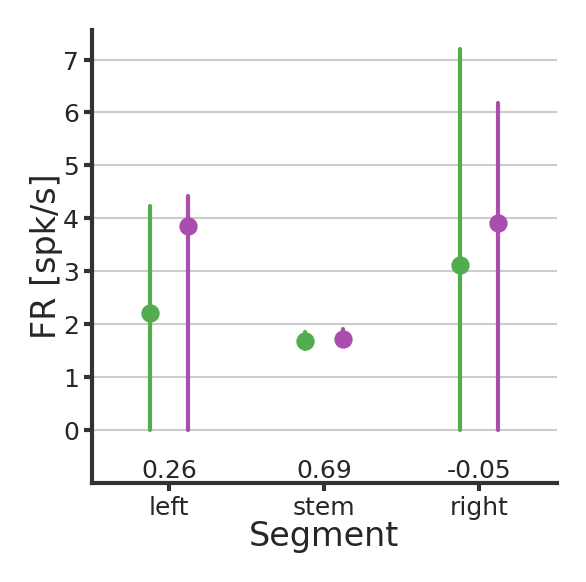

In [350]:
unit=0
comp='cue'

f,ax = plt.subplots(figsize=(2,2), dpi=300)
median_lw = 1
violin_lw = 0.75
metric_score_txt = 6
point_scale = 0.5
err_lw = 1
point_dodge = 0.25
    
if comp == 'cue':
    conds = ['CR', 'CL']
    trial_segs = ['out']*2
    cond_names = ['RC', 'LC']
    
    palette=['#51AD4E', '#AA4EAD']
elif comp == 'rw':
    conds = ['Co', 'Inco']
    trial_segs = ['in']*2
    cond_names = ['RW', 'NRW']
    palette= ['#2159AD', '#AD343A']
elif comp == 'dir':
    conds = ['Out', 'In']
    trial_segs = ['out','in']
    cond_names = ['Out', 'In']
    palette=['#AD173C', '#555971']

trials=[ta.get_condition_trials(condition=conds[0]),
        ta.get_condition_trials(condition=conds[1])]

df = pd.DataFrame()
for ii in range(2):
    res = trial_seg_rates[trial_segs[ii]][unit].loc[trials[ii]].melt(value_name='FR', 
                                                                     var_name='segment',
                                                                     ignore_index=False).reset_index(drop=True)
    res['cond'] = conds[ii]
    df = pd.concat((df,res))
df = df.reset_index(drop=True)

# sns.violinplot(data=df, x='segment', y='FR', hue='cond', split=True, 
#                inner='quartile', palette=palette, hue_order=conds[::-1], 
#                saturation=100, linewidth=violin_lw, cut=0, bw=0.4, ax=ax)
sns.pointplot(data=df, x='segment', y='FR', hue='cond',ax=ax, dodge=point_dodge, scale=point_scale, errwidth=err_lw,
              estimator=np.median, hue_order=conds[::-1], join=False, palette=palette)

seg_uz = np.zeros(3)
df = df.astype({'cond':'str', 'segment':'str'})
for ii, seg in enumerate(['left', 'stem', 'right']):
    x = df[(df.segment==seg)&(df.cond==conds[0])]['FR'].dropna()
    y = df[(df.segment==seg)&(df.cond==conds[1])]['FR'].dropna()
    
    z = rs.mannwhitney_z(x,y)
    seg_uz[ii] =  np.around(z,2)

for ii in range(3):
    ax.text((ii+0.5)/3, 0, seg_uz[ii], ha='center', va='bottom', 
            fontsize=fontsize*0.75, transform=ax.transAxes)

sns.despine(ax=ax)
ax.tick_params(axis='both', bottom=True, left=True, 
               labelsize=fontsize*0.75, pad=1, length=2, 
               width=1, color='0.2', which='major')

ax.set_xlabel("Segment", fontsize=fontsize, labelpad=0)
ax.set_ylabel(f"FR [spk/s]", fontsize=fontsize, labelpad=0)
for sp in ['bottom', 'left']:
    ax.spines[sp].set_linewidth(1)
    ax.spines[sp].set_color('0.2')

ax.grid(linewidth=0.5, axis='y')

ylims = ax.get_ylim()
yh = ylims[1]-ylims[0]
ax.set_ylim([ylims[0]-0.08*yh, ylims[1]])
#sns.swarmplot(data=df, x='segment', y='FR', hue='cond',ax=ax, dodge=True)
ax.get_legend().remove()


In [333]:
f =  plt.figure()

gs = mpl.gridspec.GridSpec(2,3,wspace=0.01, hspace=0.01, width_ratios=[0.35,0.35,0.3], 
                           top=1, bottom=0, right=1, left=0, figure=f)


<Figure size 432x288 with 0 Axes>

In [338]:
cnt = 0
axs = np.zeros(6, dtype=object)
for row in range(2):
    for col in range(3):
        axs[cnt] = f.add_axes(gs[row, col].get_position(f))
        cnt +=1
        

In [329]:
p.get_points()

array([[0.        , 0.50248756],
       [0.34768212, 1.        ]])

In [396]:
%%time
tmf = reload(tmf)
ta = tmf.TrialAnalyses(session_info)

CPU times: user 28 s, sys: 400 ms, total: 28.4 s
Wall time: 4.2 s


<AxesSubplot:xlabel='Segment', ylabel='FR [spk/s]'>

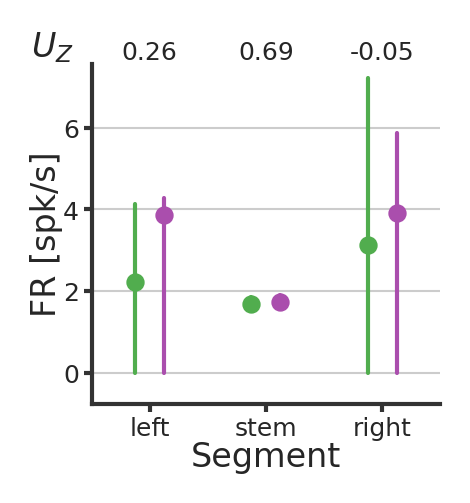

In [397]:
ta.plot_unit_seg_cond_comp(unit,comp)

In [252]:
seg_uz = np.zeros(3)
df = df.astype({'cond':'str', 'segment':'str'})
for ii, seg in enumerate(['left', 'stem', 'right']):
    x = df[(df.segment==seg)&(df.cond==conds[0])]['FR'].dropna()
    y = df[(df.segment==seg)&(df.cond==conds[1])]['FR'].dropna()
    
    z = rs.mannwhitney_z(x,y)
    seg_uz[ii] =  np.around(z,2)
seg_uz

array([ 1.01, -1.4 , -0.12])

In [364]:
x=ta.trial_zones_rates['out'][0]
#x=x/x.max().max()

In [378]:
%%time
tmf = reload(tmf)
ta = tmf.TrialAnalyses(session_info)

CPU times: user 28.1 s, sys: 419 ms, total: 28.5 s
Wall time: 4.34 s


In [381]:
%%time
a = ta.pop_zone_remapping_analyses()

CPU times: user 6.24 s, sys: 7.88 ms, total: 6.25 s
Wall time: 6.24 s


In [385]:
a["CR_bo-CL_bo-Even_bo-Odd_bo-corr_zm"]

cells   -4.070459
muas    -1.578700
units   -2.133268
Name: CR_bo-CL_bo-Even_bo-Odd_bo-corr_zm, dtype: float64

In [ ]:
tmz =  tmf.TreeMazeZones()
tmz.

In [218]:
palette

'PRGn'

<AxesSubplot:xlabel='FR', ylabel='Count'>

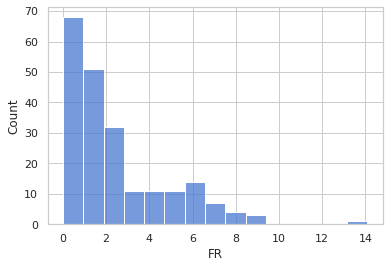

In [184]:
sns.histplot(res.FR)

interactive(children=(Dropdown(description='comp', options=('cue', 'rw', 'dir'), value='cue'), IntSlider(value…

Button(description='Save Figure', style=ButtonStyle())

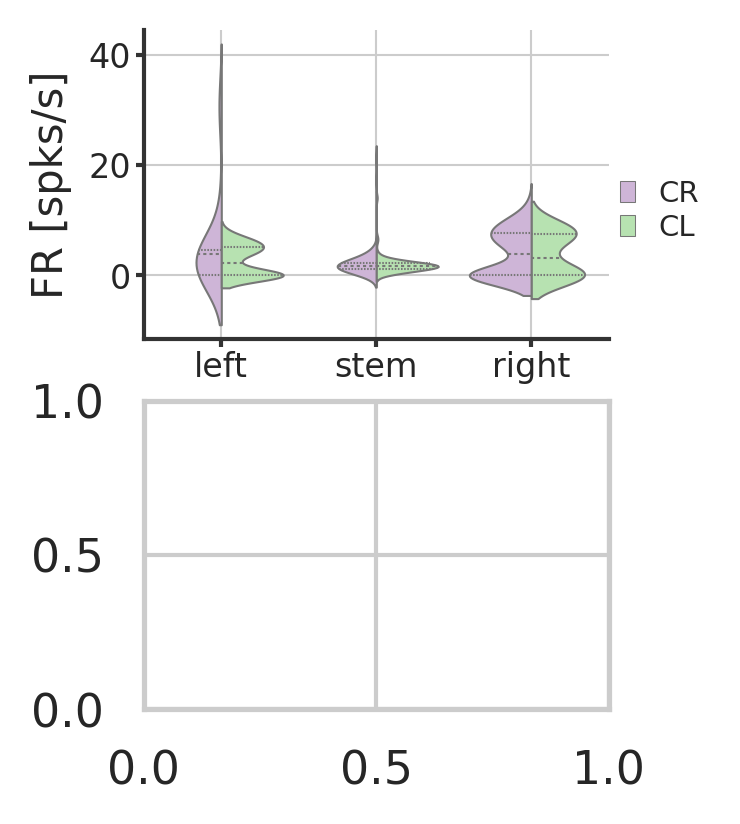

In [164]:
unit_widget2 = widgets.IntSlider(value=0, max=ta.n_units-1)
comp_widget2 = widgets.Dropdown(options=comps)
save_button2 = widgets.Button(description='Save Figure')
fontsize=10

def plot_seg_cond_comp(comp=comp_widget2, unit=unit_widget2):
    
    if comp == 'cue':
        conds = ['CR', 'CL']
        trial_segs = ['out']*2
        cond_names = ['RC', 'LC']
        palette='PRGn'
    elif comp == 'rw':
        conds = ['Co', 'Inco']
        trial_segs = ['in']*2
        cond_names = ['RW', 'NRW']
        palette='RdBu_r'
    elif comp == 'dir':
        conds = ['Out', 'In']
        trial_segs = ['out','in']
        cond_names = ['Out', 'In']
        palette='RdGy'

    
    trials=[ta.get_condition_trials(condition=conds[0]),
            ta.get_condition_trials(condition=conds[1])
           ]
    
    f,axs = plt.subplots(2,1,figsize=(2,3),dpi=300)
    fontsize=10
    
    df = pd.DataFrame()
    for ii in range(2):
        res=trial_seg_rates[trial_segs[ii]][unit].loc[trials[ii]].melt(value_name='FR', var_name='segment', ignore_index=False).reset_index(drop=True)
        res['cond'] = conds[ii]
        
        df = pd.concat((df,res))
    df = df.reset_index(drop=True)
    
    ax = axs[0]
    
    sns.violinplot(data=df, x='segment', y='FR', hue='cond', split=True, inner='quartile', palette=palette, hue_order=conds, saturation=100, linewidth=0.5, ax=ax)
    sns.despine(ax=ax)
    ax.tick_params(axis='both', bottom=True, left=True, labelsize=fontsize-2, pad=1, length=2, width=1, color='0.2', which='major')
    ax.set_xlabel("Segment",fontsize=fontsize)
    ax.set_ylabel("FR [spks/s]", fontsize=fontsize)

    for sp in ['bottom', 'left']:
        ax.spines[sp].set_linewidth(1)
        ax.spines[sp].set_color('0.2')

    ax.grid(linewidth=0.5)
    
    ax.legend()

    ha,la = ax.get_legend_handles_labels()
    ax.get_legend().remove()

    ax.legend(ha,la,bbox_to_anchor = [1.05,0.1,0.2,0.5], frameon=False, fontsize=fontsize-3,
              markerscale=0.2, handlelength=0.5, labelspacing=0.2)
    
#     ####-----##
#     zone_u_vals = trial_zone_u_comps[comp].loc[unit]
#     plot_zone_seq(zone_u_vals, legend=True, ax=axs[1])
#     axs[1].set_ylabel(f"$U_Z$", fontsize=fontsize)
            
    return f

def savefig2(*args):
    f = f2.result

    comp = f2.children[0].value
    unit = f2.children[1].value
    fn = f"{comp}_{session_info.session}_{unit}_cond_comp.png"
    f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')
    
f2 = widgets.interactive(plot_seg_cond_comp, {'comp':comp_widget2, 'unit': unit_widget2})
save_button2.on_click(savefig2)
display(f2, save_button2)

In [736]:
unit_widget = widgets.IntSlider(value=0, max=ta.n_units-1)
comp_widget = widgets.Dropdown(options=comps)
save_button = widgets.Button(description='Save Figure')

def plot_comp_cond_rates(comp=comp_widget, unit=unit_widget):
    if comp == 'cue':
        conds = ['CR', 'CL']
        trial_segs = ['out']*2
        cond_names = ['RC', 'LC']

    elif comp == 'rw':
        conds = ['Co', 'Inco']
        trial_segs = ['in']*2
        cond_names = ['RW', 'NRW']
    elif comp == 'dir':
        conds = ['Out', 'In']
        trial_segs = ['out','in']
        cond_names = ['Out', 'In']
        

    f,ax = plt.subplots(2,3,figsize=(6,4),dpi=600)
    fontsize=8
    max_val = trial_seg_rates[trial_segs[0]][unit].max().max()
    max_val = max(max_val, trial_seg_rates[trial_segs[1]][unit].max().max())
    
    for ii in range(2):
        
        plot_trial_track_spikes(trial_analyses=ta, cond=conds[ii], unit=unit, trial_seg=trial_segs[ii], ax=ax[ii,0])
        plot_zone_rates(trial_analyses=ta, cond=conds[ii], unit=unit, trial_seg=trial_segs[ii], ax=ax[ii,1], max_value=max_val)
        
        p = ax[ii,2].get_position()
        h =p.height
        w = p.width
        p = [p.x0 + w*0.1, p.y0+h*0.1, w*0.9, h*0.8]
        ax[ii,2].set_position(p)
        plot_cond_zone_seq(trial_analyses=ta, cond=conds[ii], unit=unit, trial_seg=trial_segs[ii], ax=ax[ii,2])
        ax[ii,2].set_ylabel(f"FR [spk/s]", fontsize=fontsize)
        ax[ii,2].set_ylim([0,max_val*1.1])

        
        ax[ii,0].text(-0.1,0.5, cond_names[ii], fontsize=fontsize+2, transform=ax[ii,0].transAxes)
    return f

def savefig(*args):
    f = f1.result

    comp = f1.children[0].value
    unit = f1.children[1].value
    fn = f"{comp}_{session_info.session}_{unit}_rate_cond_maps.png"
    f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')
#     p = info.paths['figures']
#     figname = f"all-trials-{session_info.session}-{f1.children[0].value}.png"   
#     f.savefig(p/figname, dpi=500, bbox_inches='tight')
    
f1 = widgets.interactive(plot_comp_cond_rates, {'comp':comp_widget, 'unit': unit_widget})
save_button.on_click(savefig)
display(f1, save_button)

interactive(children=(Dropdown(description='comp', options=('cue', 'rw', 'dir'), value='cue'), IntSlider(value…

Button(description='Save Figure', style=ButtonStyle())

In [719]:
conds = ['CR', 'CL']
trial_segs = ['out']*2
cond_names = ['RC', 'LC']
trials=[ta.get_condition_trials(condition=conds[0]),
        ta.get_condition_trials(condition=conds[1])
       ]
a = ta.zone_rate_maps_uz(cond1=conds[0], cond2=conds[1], trial_seg1=trial_segs[0], trial_seg2=trial_segs[1])

,H,a_0,a_1,a_2,a_3,a_4,a_5,a_6,D,b_0,...,e_5,i2,f_0,f_1,f_2,G3,g_0,g_1,g_2,G4
0,11.709554,-0.209850,0.206758,0.080434,0.160856,0.029220,0.143244,0.140785,0.382364,0.000000,...,0.000000,0.056077,-0.085023,0.174095,0.550625,0.057485,NaN,-2.119362,-1.312284,1.238021
1,11.709554,1.611062,0.604056,0.429434,-1.023152,0.519312,1.986494,0.873931,-0.445651,-1.215743,...,1.666068,1.610217,2.457570,0.850230,0.004049,1.410307,NaN,1.365358,-1.321793,-0.349441
2,11.709554,1.320194,1.270275,0.798884,1.186645,-0.664081,-2.163521,-0.599002,0.958546,1.312392,...,-0.507243,-0.196270,-0.170046,1.242956,0.080974,-0.574853,NaN,0.957788,0.209205,0.199681
3,11.004159,0.365245,-0.987841,0.230395,1.447707,1.460979,-0.160811,0.143442,2.205842,1.414128,...,0.936132,0.136188,1.085056,-0.485846,1.247004,1.613422,NaN,-0.101892,0.950930,0.918532
4,11.709554,-0.209850,-1.059463,-0.999287,0.400822,0.419699,-0.036487,-0.209850,2.640945,-0.137343,...,0.531987,2.735767,2.526399,1.846214,1.514220,2.812949,NaN,-0.234353,1.492960,0.359425
5,11.850633,-0.128832,-0.182433,-0.415802,0.648700,-0.091643,-1.387843,-0.447591,-0.307209,-1.205570,...,-0.103098,0.616849,-0.457505,-0.919058,-0.457505,-0.988748,NaN,0.580787,1.179153,1.847047
6,9.452291,0.236413,0.505407,0.798884,0.627604,0.375870,-0.259460,-0.231100,0.207004,-0.986838,...,0.940256,0.889224,-1.117446,-3.425214,-2.660006,-0.563356,NaN,1.059681,2.244195,0.229633
7,11.004159,0.079690,0.979733,1.277397,0.744950,0.123519,0.235136,0.621580,-0.876799,-0.116996,...,0.973248,1.289776,1.514220,1.996017,0.846182,0.026826,NaN,-0.417759,1.626091,0.129792
8,9.734448,0.690645,0.448650,0.140418,-1.532091,-0.009297,0.418920,0.196568,0.639470,0.000000,...,0.140214,1.117539,-0.522284,-0.927156,0.327946,0.548027,NaN,-0.305677,1.616581,-0.039936
9,10.439843,0.620252,0.862165,0.196313,-1.042930,0.418371,1.122977,1.341445,0.937450,0.681630,...,1.641324,-0.020028,-1.016228,-0.311751,1.307735,0.003832,NaN,-0.570597,0.351844,0.619010


In [706]:
x=ta.get_unit_trial_zone_rates(4, trials=trials[0])
y=ta.get_unit_trial_zone_rates(4, trials=trials[1])
rs.mannwhitney_z(x,y)

ValueError: `x` and `y` must be of nonzero size.

In [717]:
x[(x.isna().sum()==x.shape[0]).idxmax()]=0
y[(y.isna().sum()==y.shape[0]).idxmax()]=0
o = rs.mannwhitney_z(x,y)
o[(x.isna().sum()==x.shape[0]).idxmax()]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

'g_0'

In [675]:

        
zone_t_vals = ta.zone_rate_maps_t(cond1=conds[0], cond2=conds[1], trial_seg1=trial_segs[0], trial_seg2=trial_segs[1])
zone_t_vals

,H,a_0,a_1,a_2,a_3,a_4,a_5,a_6,D,b_0,...,e_5,i2,f_0,f_1,f_2,G3,g_0,g_1,g_2,G4
0,-2.381481,2.192312,1.854563,1.184819,1.733509,3.213779,1.113322,0.785757,0.610492,-1.988368,...,0.590877,0.688091,0.268048,-0.551893,-2.868858,-0.197754,0.417625,0.928548,1.477013,2.064528
1,3.696501,1.433993,-0.013781,0.953375,1.040143,-0.279393,-0.176136,0.943302,0.375231,-1.351188,...,0.360202,-0.216324,-0.535024,-0.836561,-0.587341,2.341000,-0.050401,-0.660168,-0.425346,0.684911
2,0.083940,0.054509,-0.885290,0.296957,-0.342289,-0.818704,-0.638016,1.620160,2.118844,-1.597631,...,0.602880,-0.221377,0.993219,-0.536332,-0.036203,-1.299596,-2.193646,-1.824775,-0.617524,-0.002319
3,-0.712101,1.583977,0.796443,2.079344,0.800009,0.706583,-0.870269,1.142728,0.152289,0.466867,...,-1.604208,-0.286634,1.655623,0.064397,1.486675,2.973532,0.293959,-0.412167,-0.032028,-1.065339
4,-0.241752,-0.222798,-0.227094,0.244590,-0.690595,1.340399,-0.428788,1.376727,0.523719,0.040516,...,-0.702940,-0.208690,-0.087906,-0.771716,0.201996,-0.898812,1.170282,0.491771,0.311634,1.042724
5,1.170744,-5.281450,-4.651667,-4.437774,-2.865195,-1.565829,0.161306,-0.612919,0.801205,0.864059,...,1.302813,0.861163,-0.291217,-0.463885,-0.807739,0.876843,1.898470,1.360821,-0.336995,0.164045
6,-0.938308,-1.298881,0.941383,-1.208078,-0.228907,1.700439,0.108925,0.296033,2.427927,0.699637,...,-0.161401,-0.048860,-0.947458,0.738480,1.514799,2.611823,-1.148002,-0.853827,0.532085,-0.856547
7,1.643052,-1.113482,1.758153,0.294810,0.531171,-0.496233,-0.844839,0.993819,2.783427,-1.605999,...,0.606181,0.018706,0.413876,-0.912926,-0.037515,1.558024,0.630189,0.010136,-1.206199,-0.023073
8,0.490290,1.710627,3.678327,0.685829,-1.173342,0.383091,0.387275,0.895590,0.032206,-0.620075,...,-0.565044,1.001637,1.151652,-0.840776,0.787335,1.938403,-0.102333,-0.084972,0.705027,-0.520045
9,2.237989,1.175543,-0.003637,0.316603,-0.473247,0.856709,1.296280,-0.609042,1.502310,3.089630,...,-0.504526,-0.620388,-0.731826,-0.279081,-0.615211,0.744533,0.940100,-0.180548,-0.976977,0.770721


(<Figure size 750x540 with 1 Axes>, <AxesSubplot:xlabel='Zone'>)

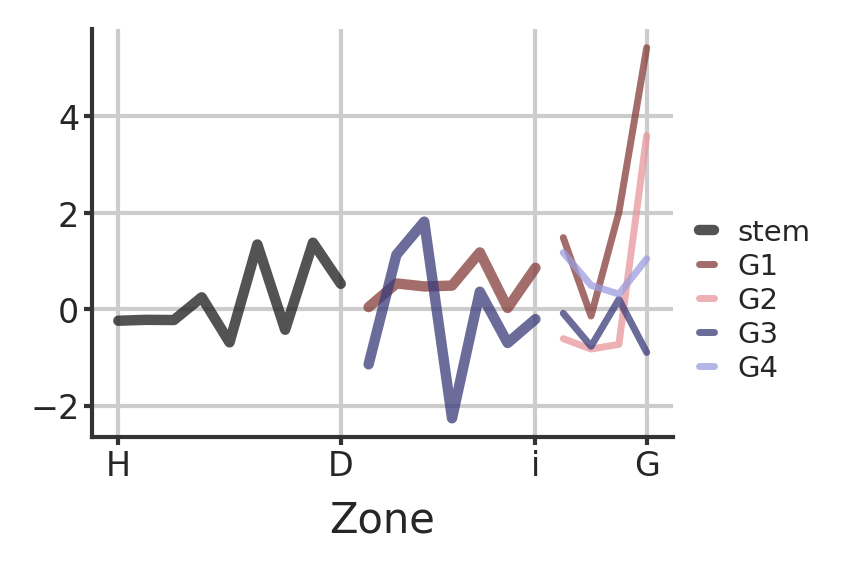

(<Figure size 600x600 with 2 Axes>,
 <AxesSubplot:xlabel='Segment', ylabel='$U_Z$'>,
 <Axes:>)

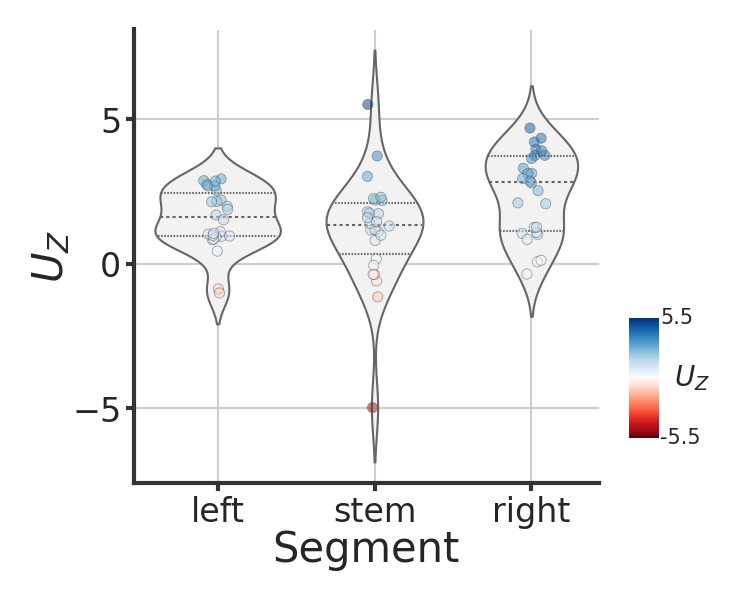

In [638]:
tmf=reload(tmf)

comp = 'rw'
segment_t_vals = tmf.rate_segment_comp_analysis(session_info, comp=comp, ta=ta)
plot_comp_score_x_seg(segment_t_vals,comp=comp, metric='uz_val')